In [179]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf ÌååÏùºÏù¥ Ï†ÄÏû•ÎêòÏñ¥ ÏûàÎäî Í≤ΩÎ°ú
    name='NanumBarunGothic')                        # Ïù¥ Ìè∞Ìä∏Ïùò ÏõêÌïòÎäî Ïù¥Î¶Ñ ÏÑ§Ï†ï
fm.fontManager.ttflist.insert(0, fe)              # MatplotlibÏóê Ìè∞Ìä∏ Ï∂îÍ∞Ä
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # Ìè∞Ìä∏ ÏÑ§Ï†ï
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns
# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

from lightgbm import LGBMRegressor, early_stopping, log_evaluation

import eli5
from eli5.sklearn import PermutationImportance

from sklearn.preprocessing import MinMaxScaler
#standardscaler
from sklearn.preprocessing import StandardScaler
#robustscaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import StratifiedKFold

In [180]:
# Í≥ÑÏïΩÎÖÑÏõî formatting
def str_to_datetime(df: pd.DataFrame, col: str) -> pd.DataFrame:
    # Î¨∏ÏûêÏó¥ÏóêÏÑú ÌäπÏàòÎ¨∏Ïûê Ï†úÍ±∞('-')
    df[col] = df[col].astype(str).str.replace('-', '')
    # Î¨∏ÏûêÏó¥ÏùÑ datetimeÏúºÎ°ú Î≥ÄÌôò
    df[col] = pd.to_datetime(df[col], format='%Y%m')
    df[col] = df[col].dt.strftime('%Y-%m')
    return df
    

# target encoding Ìï®Ïàò
def target_encoding(df_train: pd.DataFrame, df_test: pd.DataFrame, target_col: str, encode_col: str, 
                   alpha: float = 0.5, global_mean: float = None) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_encoded_train = df_train.copy()
    df_encoded_test = df_test.copy()
    
    # Ï†ÑÏ≤¥ ÌèâÍ∑† Í≥ÑÏÇ∞
    if global_mean is None:
        global_mean = df_train[target_col].mean()
    
    # Ïπ¥ÌÖåÍ≥†Î¶¨Î≥Ñ ÌÜµÍ≥Ñ Í≥ÑÏÇ∞
    category_stats = df_train.groupby(encode_col).agg({
        target_col: ['count', 'mean']
    }).reset_index()
    
    category_stats.columns = [encode_col, 'count', 'mean']
    
    # # Ïä§Î¨¥Îî© Ï†ÅÏö©
    # category_stats['smoothed_mean'] = (
    #     (category_stats['count'] * category_stats['mean'] + alpha * global_mean) / 
    #     (category_stats['count'] + alpha)
    # )
    
    # Ïù∏ÏΩîÎî© Ï†ÅÏö©
    encoding_map = dict(zip(category_stats[encode_col], category_stats['mean']))
    
    # ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Ïóê Ï†ÅÏö©
    df_encoded_train[f'{encode_col}_target'] = df_encoded_train[encode_col].map(encoding_map)
    
    # ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïóê Ï†ÅÏö© (ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Ïóê ÏóÜÎäî Ïπ¥ÌÖåÍ≥†Î¶¨Îäî Ï†ÑÏ≤¥ ÌèâÍ∑† ÏÇ¨Ïö©)
    df_encoded_test[f'{encode_col}_target'] = df_encoded_test[encode_col].map(encoding_map)
    df_encoded_test[f'{encode_col}_target'].fillna(global_mean, inplace=True)
    
    return df_encoded_train, df_encoded_test
    
# Îèô target encoding Ìï®Ïàò
def dong_target_encoding(df_train: pd.DataFrame, df_test: pd.DataFrame, target_col: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_encoded_train = df_train.copy()
    df_encoded_test = df_test.copy()

    #Îèô target encodingÏùÄ Íµ¨ ÌèâÍ∑† ÏßëÍ∞íÏóê ÎåÄÌïú ÎπÑÏú®Î°ú encoding
    df_gu_dong = df_encoded_train.groupby(['Íµ¨', 'Îèô'])[target_col].mean().reset_index()
    df_gu = df_encoded_train.groupby('Íµ¨')[target_col].mean().reset_index()
    df_gu.columns = ['Íµ¨', 'Íµ¨_target']
    df_gu_dong = df_gu_dong.merge(df_gu, on='Íµ¨', how='left')
    df_gu_dong['Îèô_target'] = df_gu_dong[target_col] / df_gu_dong['Íµ¨_target']
    

    encoding_map = dict(zip(df_gu_dong['Îèô'], df_gu_dong['Îèô_target']))

    df_encoded_train['Îèô_target'] = df_encoded_train['Îèô'].map(encoding_map)
    df_encoded_test['Îèô_target'] = df_encoded_test['Îèô'].map(encoding_map)

    # ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Í≤∞Ï∏°Ïπò Ï±ÑÏö∏ Îïå Íµ¨ ÌèâÍ∑† ÏÇ¨Ïö©
    df_encoded_test['Îèô_target'].fillna(1, inplace=True)

    return df_encoded_train, df_encoded_test

# ÏïÑÌååÌä∏Î™Ö target encoding Ìï®Ïàò
def apartment_target_encoding(df_train: pd.DataFrame, df_test: pd.DataFrame, target_col: str, alpha: float = 0.5) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_encoded_train = df_train.copy()
    df_encoded_test = df_test.copy()

    # ÏïÑÌååÌä∏Î™Ö Î©¥Ï†ÅÎãπÍ∞ÄÍ≤©
    df_cost_area = df_encoded_train.groupby(['ÏïÑÌååÌä∏Î™Ö', 'Íµ¨', 'Îèô'])[['Ï†ÑÏö©Î©¥Ï†Å', target_col]].agg(['count', 'mean']).reset_index()
    df_cost_area.columns = ['ÏïÑÌååÌä∏Î™Ö', 'Íµ¨', 'Îèô', '_', 'area_mean', 'count', 'target_mean']
    df_cost_area['Î©¥Ï†ÅÎãπÍ∞ÄÍ≤©'] = df_cost_area['target_mean'] / df_cost_area['area_mean']

    # Íµ¨ Î©¥Ï†ÅÎãπÍ∞ÄÍ≤©
    df_gu = df_encoded_train.groupby('Íµ¨')[['Ï†ÑÏö©Î©¥Ï†Å', target_col]].mean().reset_index()
    df_gu['Î©¥Ï†ÅÎãπÍ∞ÄÍ≤©'] = df_gu[target_col] / df_gu['Ï†ÑÏö©Î©¥Ï†Å']

    # Íµ¨ Î©¥Ï†ÅÎãπÍ∞ÄÍ≤© Îß§Ìïë
    gu_encoding_map = dict(zip(df_gu['Íµ¨'], df_gu['Î©¥Ï†ÅÎãπÍ∞ÄÍ≤©']))
    df_cost_area['Íµ¨_Î©¥Ï†ÅÎãπÍ∞ÄÍ≤©'] = df_cost_area['Íµ¨'].map(gu_encoding_map)

    df_cost_area['Î©¥Ï†ÅÎãπÍ∞ÄÍ≤©_smoothed'] = (
        (df_cost_area['Î©¥Ï†ÅÎãπÍ∞ÄÍ≤©'] * df_cost_area['count'] + alpha * df_cost_area['Íµ¨_Î©¥Ï†ÅÎãπÍ∞ÄÍ≤©']) / 
        (df_cost_area['count'] + alpha)
    )
    

    # Îèô Î©¥Ï†ÅÎãπÍ∞ÄÍ≤© 
    df_dong = df_encoded_train.groupby('Îèô')[['Ï†ÑÏö©Î©¥Ï†Å', target_col]].mean().reset_index()
    df_dong['Î©¥Ï†ÅÎãπÍ∞ÄÍ≤©'] = df_dong[target_col] / df_dong['Ï†ÑÏö©Î©¥Ï†Å']

    # Îèô Î©¥Ï†ÅÎãπÍ∞ÄÍ≤© Îß§Ìïë
    dong_encoding_map = dict(zip(df_dong['Îèô'], df_dong['Î©¥Ï†ÅÎãπÍ∞ÄÍ≤©']))
    df_cost_area['Îèô_Î©¥Ï†ÅÎãπÍ∞ÄÍ≤©'] = df_cost_area['Îèô'].map(dong_encoding_map)

    # ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Í≤∞Ï∏°Ïπò Ï±ÑÏö∏ Îïå Îèô Î©¥Ï†ÅÎãπÍ∞ÄÍ≤© ÌòπÏùÄ Íµ¨ Î©¥Ï†ÅÎãπÍ∞ÄÍ≤©ÏúºÎ°ú Ï±ÑÏö∞Í∏∞
    df_encoded_test['Îèô_Î©¥Ï†ÅÎãπÍ∞ÄÍ≤©'] = df_encoded_test['Îèô'].map(dong_encoding_map)
    df_encoded_test['Íµ¨_Î©¥Ï†ÅÎãπÍ∞ÄÍ≤©'] = df_encoded_test['Íµ¨'].map(gu_encoding_map)

    # ÏïÑÌååÌä∏Î™Ö Î©¥Ï†ÅÎãπÍ∞ÄÍ≤© Îß§Ìïë
    df_encoding_map = dict(zip(df_cost_area['ÏïÑÌååÌä∏Î™Ö'], df_cost_area['Î©¥Ï†ÅÎãπÍ∞ÄÍ≤©_smoothed']))
    df_encoded_train['ÏïÑÌååÌä∏Î™Ö_Î©¥Ï†ÅÎãπÍ∞ÄÍ≤©'] = df_encoded_train['ÏïÑÌååÌä∏Î™Ö'].map(df_encoding_map)
    df_encoded_test['ÏïÑÌååÌä∏Î™Ö_Î©¥Ï†ÅÎãπÍ∞ÄÍ≤©'] = df_encoded_test['ÏïÑÌååÌä∏Î™Ö'].map(df_encoding_map)
    df_encoded_test['ÏïÑÌååÌä∏Î™Ö_Î©¥Ï†ÅÎãπÍ∞ÄÍ≤©'].fillna(df_encoded_test['Îèô_Î©¥Ï†ÅÎãπÍ∞ÄÍ≤©'], inplace=True)
    df_encoded_test['ÏïÑÌååÌä∏Î™Ö_Î©¥Ï†ÅÎãπÍ∞ÄÍ≤©'].fillna(df_encoded_test['Íµ¨_Î©¥Ï†ÅÎãπÍ∞ÄÍ≤©'], inplace=True)
    df_encoded_test.drop(columns=['Îèô_Î©¥Ï†ÅÎãπÍ∞ÄÍ≤©', 'Íµ¨_Î©¥Ï†ÅÎãπÍ∞ÄÍ≤©'], inplace=True)

    df_encoded_train.drop(columns=['ÏïÑÌååÌä∏Î™Ö', 'Íµ¨', 'Îèô', 'ÏãúÍµ∞Íµ¨'], inplace=True)
    df_encoded_test.drop(columns=['ÏïÑÌååÌä∏Î™Ö', 'Íµ¨', 'Îèô', 'ÏãúÍµ∞Íµ¨'], inplace=True)
    return df_encoded_train, df_encoded_test

# ÎùºÎ≤® Ïù∏ÏΩîÎî© Ìï®Ïàò
def label_encoding(df_train: pd.DataFrame, df_test: pd.DataFrame, excp: list = []) -> tuple[pd.DataFrame, pd.DataFrame, dict]:
    dt_train = df_train.copy()
    dt_test = df_test.copy()
    categorical_features = dt_train.select_dtypes(include=[np.object]).columns
    categorical_features = categorical_features.drop(excp)
    # Í∞Å Î≥ÄÏàòÏóê ÎåÄÌïú LabelEncoderÎ•º Ï†ÄÏû•Ìï† ÎîïÏÖîÎÑàÎ¶¨
    label_encoders = {}

    # Implement Label Encoding
    for col in tqdm( categorical_features ):
        # Î™®Îì† Í≥†Ïú†Í∞í ÏàòÏßë (ÌïôÏäµ + ÌÖåÏä§Ìä∏)

        # Î™®Îì† Í≥†Ïú†Í∞í ÏàòÏßë (ÌïôÏäµ + ÌÖåÏä§Ìä∏)
        all_unique_values = pd.concat([dt_train[col], dt_test[col]]).unique()
        
        # Î†àÏù¥Î∏î Ïù∏ÏΩîÎçî ÏÉùÏÑ± Î∞è ÌïôÏäµ
        lbl = LabelEncoder()
        lbl.fit(all_unique_values.astype(str))  # Î¨∏ÏûêÏó¥Î°ú Î≥ÄÌôò
        
        # Î≥ÄÌôò
        dt_train[col] = lbl.transform(dt_train[col].astype(str))
        dt_test[col] = lbl.transform(dt_test[col].astype(str))
        
        label_encoders[col] = lbl
    return dt_train, dt_test, label_encoders

# Í≥ÑÏïΩÎÖÑÏõî 2017ÎÖÑ Ï†ÑÌõÑ Ìä∏Î†åÎìúÎ°ú encoidng ÌïòÎäî Ìï®Ïàò
from sklearn.linear_model import LinearRegression

def contract_encoding(df_train:pd.DataFrame, df_test:pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
  df_train_copy = df_train.copy()
  df_test_copy = df_test.copy()

  df_train_copy = str_to_datetime(df_train_copy, 'Í≥ÑÏïΩÎÖÑÏõî')
  df_test_copy = str_to_datetime(df_test_copy, 'Í≥ÑÏïΩÎÖÑÏõî')

  df_time_check = df_train_copy.groupby('Í≥ÑÏïΩÎÖÑÏõî')['target'].mean().reset_index()
  df_time_check.sort_values(by='Í≥ÑÏïΩÎÖÑÏõî', inplace=True)
  df_time_check['Í≥ÑÏïΩÎÖÑÏõî'] = pd.to_datetime(df_time_check['Í≥ÑÏïΩÎÖÑÏõî']).dt.strftime('%Y-%m')
  
  # Í≥ÑÏïΩÎÖÑÏõîÏùÑ datetimeÏúºÎ°ú Î≥ÄÌôò
  df_time_check['Í≥ÑÏïΩÎÖÑÏõî'] = pd.to_datetime(df_time_check['Í≥ÑÏïΩÎÖÑÏõî'])
  df_time_check = df_time_check.sort_values('Í≥ÑÏïΩÎÖÑÏõî').reset_index(drop=True)
  df_time_check['Ïó∞ÎèÑ'] = df_time_check['Í≥ÑÏïΩÎÖÑÏõî'].dt.year

  # 2017ÎÖÑ Í∏∞Ï§ÄÏúºÎ°ú Îç∞Ïù¥ÌÑ∞ ÎÇòÎàÑÍ∏∞
  df_before_2017 = df_time_check[df_time_check['Ïó∞ÎèÑ'] < 2017].copy()
  df_after_2017 = df_time_check[df_time_check['Ïó∞ÎèÑ'] >= 2017].copy()

  # Ïù∏ÏΩîÎî© Îßµ Ï†ÄÏû•Ïö© dict
  encoding_map = {}


  # Ïù∏ÏΩîÎî© Í∞í ÏÉùÏÑ±
  def trend_encode(df, label):
      if len(df) < 2:
          return None
      n = len(df)
      y_start = df['target'].values[:3].mean()
      x = np.arange(n).reshape(-1, 1)
      y = df['target'].values.reshape(-1, 1)
      model = LinearRegression().fit(x, y)
      y_end = model.predict([[n - 1]])[0][0]
      y_trend = np.linspace(y_start, y_end, n)

      # Ïù∏ÏΩîÎî© ÎßµÏóê Ï†ÄÏû•
      for i, dt in enumerate(df['Í≥ÑÏïΩÎÖÑÏõî']):
          ym_str = dt.strftime('%Y-%m')
          encoding_map[ym_str] = y_trend[i]

      return model, y_start, n

  # Í∞Å Íµ¨Í∞ÑÎ≥Ñ Ï∂îÏÑ∏ÏÑ† Î∞è Ïù∏ÏΩîÎî©
  model_before, _, _ = trend_encode(df_before_2017, '2017ÎÖÑ Ïù¥Ï†Ñ Ï∂îÏÑ∏')
  model_after, y_start_after, n_after = trend_encode(df_after_2017, '2017ÎÖÑ Ïù¥ÌõÑ Ï∂îÏÑ∏')

  # === 3Í∞úÏõî ÎØ∏Îûò ÏòàÏ∏° ===
  future_months = 3
  last_date = df_after_2017['Í≥ÑÏïΩÎÖÑÏõî'].max()

  for i in range(1, future_months + 1):
      future_date = last_date + pd.DateOffset(months=i)
      x_future = np.array([[n_after - 1 + i]])
      y_future = model_after.predict(x_future)[0][0]
      encoding_map[future_date.strftime('%Y-%m')] = y_future

  df_train_copy['Í≥ÑÏïΩÎÖÑÏõî'] = df_train_copy['Í≥ÑÏïΩÎÖÑÏõî'].map(encoding_map)
  df_test_copy['Í≥ÑÏïΩÎÖÑÏõî'] = df_test_copy['Í≥ÑÏïΩÎÖÑÏõî'].map(encoding_map)

  return df_train_copy, df_test_copy


In [181]:
#ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
whole = pd.read_csv("./../../Datas/updated_df2(knn).csv")


# ÏÇ¥Î¶¥ columnÎì§ Ï†ïÎ¶¨
use_cols = np.array(['Ï†ÑÏö©Î©¥Ï†Å', 'Í≥ÑÏïΩÎÖÑÏõî', 'Ï∏µ','Í±∞ÎûòÏú†Ìòï', 'k-Ï†ÑÏ≤¥ÎèôÏàò',
'k-Ï†ÑÏ≤¥ÏÑ∏ÎåÄÏàò', 'k-Ïó∞Î©¥Ï†Å', 'Ï£ºÏ∞®ÎåÄÏàò', 'lat', 'long', 'target', 
'ÏãúÍµ∞Íµ¨', 'ÏïÑÌååÌä∏Î™Ö', 'k-Îã®ÏßÄÎ∂ÑÎ•ò(ÏïÑÌååÌä∏,Ï£ºÏÉÅÎ≥µÌï©Îì±Îì±)', 'k-ÏÑ∏ÎåÄÌÉÄÏûÖ(Î∂ÑÏñëÌòïÌÉú)',
'k-Î≥µÎèÑÏú†Ìòï', 'k-ÎÇúÎ∞©Î∞©Ïãù', 'k-Í±¥ÏÑ§ÏÇ¨(ÏãúÍ≥µÏÇ¨)', 'k-ÏãúÌñâÏÇ¨', 'k-ÌôàÌéòÏù¥ÏßÄ',
'is_test', 'ÌïôÍµ∞', 'Ïò§ÎßàÏπ¥ÏÑ∏', 'ÌïúÍ∞ïÎ≥Ä', 'Ïã†Ï∂ïÏó¨Î∂Ä', 'Í±¥Î¨ºÏó∞Ïãù'
])


df = whole[use_cols]

df['Íµ¨'] = df['ÏãúÍµ∞Íµ¨'].str.split(' ').str[1]
df['Îèô'] = df['ÏãúÍµ∞Íµ¨'].str.split(' ').str[1] + ' ' + df['ÏãúÍµ∞Íµ¨'].str.split(' ').str[2]
df_train = df[df['is_test'] == 0]
df_test = df[df['is_test'] == 1]
df_train.drop(columns=['is_test'], inplace=True)
df_test.drop(columns=['is_test', 'target'], inplace=True)



Í∞Å Íµ¨Î≥Ñ ÏµúÏ¢Ö ÎåÄÌëúÍ∞í:
       Íµ¨  smoothed_target
0    Í∞ïÎÇ®Íµ¨    195504.667390
1    Í∞ïÎèôÍµ¨     93856.557096
2    Í∞ïÎ∂ÅÍµ¨     54456.386708
3    Í∞ïÏÑúÍµ¨     69552.643644
4    Í¥ÄÏïÖÍµ¨     63467.091339
5    Í¥ëÏßÑÍµ¨    100796.547568
6    Íµ¨Î°úÍµ¨     52124.778352
7    Í∏àÏ≤úÍµ¨     55866.642313
8    ÎÖ∏ÏõêÍµ¨     59338.480091
9    ÎèÑÎ¥âÍµ¨     50072.866787
10  ÎèôÎåÄÎ¨∏Íµ¨     67927.896180
11   ÎèôÏûëÍµ¨     92143.372292
12   ÎßàÌè¨Íµ¨    109798.772123
13  ÏÑúÎåÄÎ¨∏Íµ¨     80887.737803
14   ÏÑúÏ¥àÍµ¨    204343.363089
15   ÏÑ±ÎèôÍµ¨    125083.052860
16   ÏÑ±Î∂ÅÍµ¨     69651.193956
17   ÏÜ°ÌååÍµ¨    154299.419512
18   ÏñëÏ≤úÍµ¨     97646.094495
19  ÏòÅÎì±Ìè¨Íµ¨     88167.468788
20   Ïö©ÏÇ∞Íµ¨    178426.760228
21   ÏùÄÌèâÍµ¨     64343.556737
22   Ï¢ÖÎ°úÍµ¨     74261.535575
23    Ï§ëÍµ¨     80304.032400
24   Ï§ëÎûëÍµ¨     52540.960494


(array([200600., 200800., 201000., 201200., 201400., 201600., 201800.,
        202000., 202200., 202400.]),
 [Text(200600.0, 0, '200600'),
  Text(200800.0, 0, '200800'),
  Text(201000.0, 0, '201000'),
  Text(201200.0, 0, '201200'),
  Text(201400.0, 0, '201400'),
  Text(201600.0, 0, '201600'),
  Text(201800.0, 0, '201800'),
  Text(202000.0, 0, '202000'),
  Text(202200.0, 0, '202200'),
  Text(202400.0, 0, '202400')])

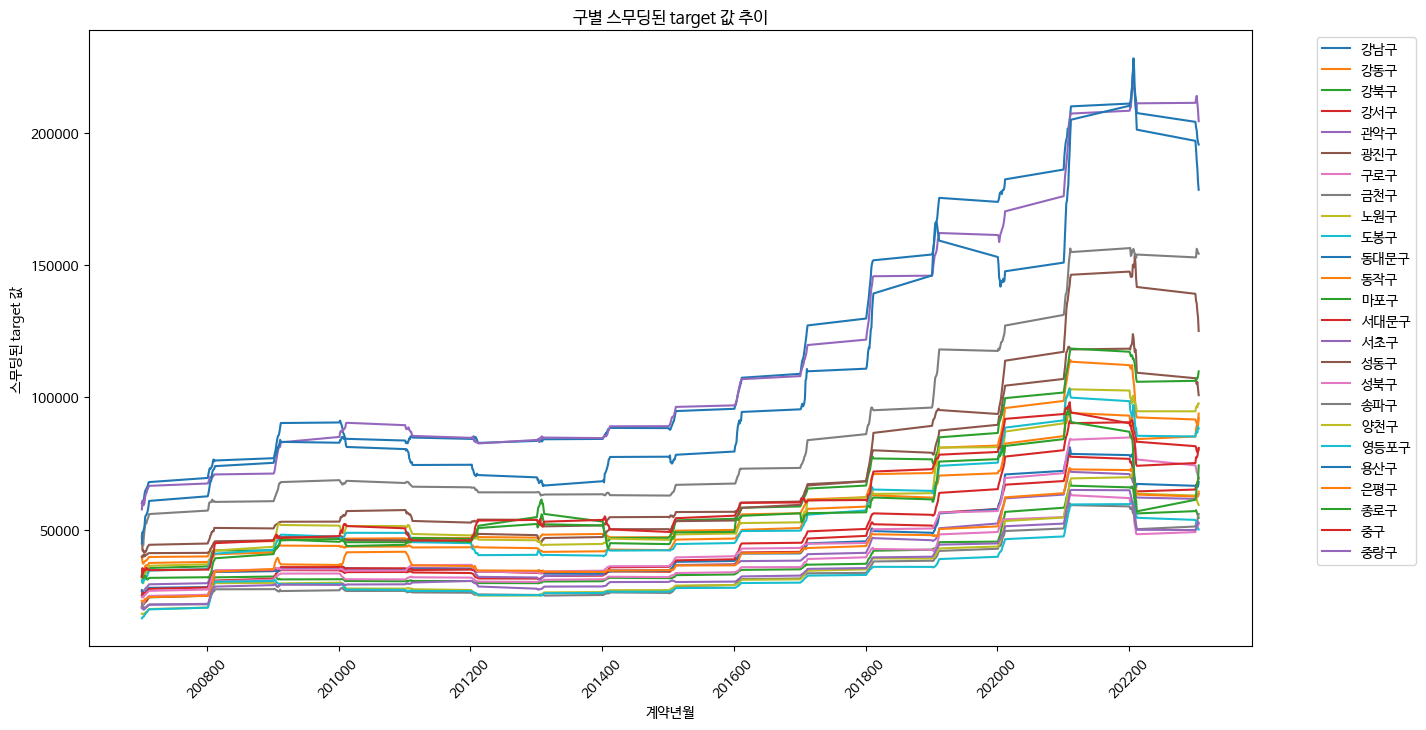

In [182]:
# Íµ¨Î≥Ñ, Í≥ÑÏïΩÎÖÑÏõîÎ≥Ñ target Í∞íÏùò Ïù¥ÎèôÌèâÍ∑† Í≥ÑÏÇ∞
smoothed_values = df_train.groupby(['Íµ¨', 'Í≥ÑÏïΩÎÖÑÏõî'])['target'].mean().reset_index()

# Í∞Å Íµ¨Î≥ÑÎ°ú 12Í∞úÏõî Ïù¥ÎèôÌèâÍ∑† Í≥ÑÏÇ∞
smoothed_values['smoothed_target'] = smoothed_values.groupby('Íµ¨')['target'].transform(
    lambda x: x.rolling(window=12, min_periods=1).mean()
)


# Í∞Å Íµ¨Î≥Ñ ÏµúÏ¢Ö ÎåÄÌëúÍ∞í Í≥ÑÏÇ∞ (ÏµúÍ∑º 12Í∞úÏõî ÌèâÍ∑†)
final_representative = smoothed_values.groupby('Íµ¨')['smoothed_target'].last().reset_index()
print("\nÍ∞Å Íµ¨Î≥Ñ ÏµúÏ¢Ö ÎåÄÌëúÍ∞í:")
print(final_representative)

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(15, 8))
for district in final_representative['Íµ¨'].unique():
    district_data = smoothed_values[smoothed_values['Íµ¨'] == district]
    plt.plot(district_data['Í≥ÑÏïΩÎÖÑÏõî'], district_data['smoothed_target'], label=district)

plt.title('Íµ¨Î≥Ñ Ïä§Î¨¥Îî©Îêú target Í∞í Ï∂îÏù¥')
plt.xlabel('Í≥ÑÏïΩÎÖÑÏõî')
plt.ylabel('Ïä§Î¨¥Îî©Îêú target Í∞í')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)



In [183]:
# ÏßëÍ∞í ÏàúÏÑúÎåÄÎ°ú Íµ¨ Ï†ïÎ†¨
final_representative = final_representative.sort_values(by='smoothed_target', ascending=False)
display(final_representative)

# ÏßëÍ∞í ÏÑúÏó¥ ÎåÄÎ°ú ÎÜíÏùÄ Í∑∏Î£π, Ï§ëÍ∞Ñ Í∑∏Î£π, ÎÇÆÏùÄ Í∑∏Î£πÏúºÎ°ú ÎÇòÎàÑÍ∏∞ÎàÑÍ∏∞
target_order_list = final_representative['Íµ¨'].values
display(target_order_list)
high_group = target_order_list[:3]
mid_group = target_order_list[3:5]
low_group = target_order_list[5:]

Íµ¨  smoothed_target
14   ÏÑúÏ¥àÍµ¨    204343.363089
0    Í∞ïÎÇ®Íµ¨    195504.667390
20   Ïö©ÏÇ∞Íµ¨    178426.760228
17   ÏÜ°ÌååÍµ¨    154299.419512
15   ÏÑ±ÎèôÍµ¨    125083.052860
12   ÎßàÌè¨Íµ¨    109798.772123
5    Í¥ëÏßÑÍµ¨    100796.547568
18   ÏñëÏ≤úÍµ¨     97646.094495
1    Í∞ïÎèôÍµ¨     93856.557096
11   ÎèôÏûëÍµ¨     92143.372292
19  ÏòÅÎì±Ìè¨Íµ¨     88167.468788
13  ÏÑúÎåÄÎ¨∏Íµ¨     80887.737803
23    Ï§ëÍµ¨     80304.032400
22   Ï¢ÖÎ°úÍµ¨     74261.535575
16   ÏÑ±Î∂ÅÍµ¨     69651.193956
3    Í∞ïÏÑúÍµ¨     69552.643644
10  ÎèôÎåÄÎ¨∏Íµ¨     67927.896180
21   ÏùÄÌèâÍµ¨     64343.556737
4    Í¥ÄÏïÖÍµ¨     63467.091339
8    ÎÖ∏ÏõêÍµ¨     59338.480091
7    Í∏àÏ≤úÍµ¨     55866.642313
2    Í∞ïÎ∂ÅÍµ¨     54456.386708
24   Ï§ëÎûëÍµ¨     52540.960494
6    Íµ¨Î°úÍµ¨     52124.778352
9    ÎèÑÎ¥âÍµ¨     50072.866787

array(['ÏÑúÏ¥àÍµ¨', 'Í∞ïÎÇ®Íµ¨', 'Ïö©ÏÇ∞Íµ¨', 'ÏÜ°ÌååÍµ¨', 'ÏÑ±ÎèôÍµ¨', 'ÎßàÌè¨Íµ¨', 'Í¥ëÏßÑÍµ¨', 'ÏñëÏ≤úÍµ¨', 'Í∞ïÎèôÍµ¨',
       'ÎèôÏûëÍµ¨', 'ÏòÅÎì±Ìè¨Íµ¨', 'ÏÑúÎåÄÎ¨∏Íµ¨', 'Ï§ëÍµ¨', 'Ï¢ÖÎ°úÍµ¨', 'ÏÑ±Î∂ÅÍµ¨', 'Í∞ïÏÑúÍµ¨', 'ÎèôÎåÄÎ¨∏Íµ¨', 'ÏùÄÌèâÍµ¨',
       'Í¥ÄÏïÖÍµ¨', 'ÎÖ∏ÏõêÍµ¨', 'Í∏àÏ≤úÍµ¨', 'Í∞ïÎ∂ÅÍµ¨', 'Ï§ëÎûëÍµ¨', 'Íµ¨Î°úÍµ¨', 'ÎèÑÎ¥âÍµ¨'], dtype=object)

In [184]:
# # Í∞Å Í∑∏Î£π Í∞Ñ Îç∞Ïù¥ÌÑ∞ Í∞úÏàò ÌååÏïÖ
# df_high = df_train[df_train['Íµ¨'].isin(high_group)]
# df_mid = df_train[df_train['Íµ¨'].isin(mid_group)]
# df_low = df_train[df_train['Íµ¨'].isin(low_group)]
# display(len(df_high))
# display(len(df_mid))
# display(len(df_low))


In [196]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

def model_traning_by_price(df_train:pd.DataFrame, df_test:pd.DataFrame) -> tuple:
    df_train = df_train.copy()
    df_test = df_test.copy()

    numeric_features = df_train.select_dtypes(include=[np.number]).columns
    categorical_features = df_train.select_dtypes(include=[np.object]).columns

    df_train[categorical_features] = df_train[categorical_features].fillna('NULL')
    df_test[categorical_features] = df_test[categorical_features].fillna('NULL')

    #Î†àÏù¥Î∏î Ïù∏ÏΩîÎî©
    df_train, df_test, label_encoders = label_encoding(df_train, df_test,['ÏïÑÌååÌä∏Î™Ö', 'Íµ¨', 'Îèô'])

    # Í∑∏Î£πÎ≥Ñ Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨
    df_high = df_train[df_train['Íµ¨'].isin(high_group)].copy()
    df_mid = df_train[df_train['Íµ¨'].isin(mid_group)].copy()
    df_low = df_train[df_train['Íµ¨'].isin(low_group)].copy()

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # GroupKFold ÏÑ§Ï†ï
    # n_splits = 5
    # gkf = GroupKFold(n_splits=n_splits)

    # Í≥µÌÜµ Ìï®Ïàò Ï†ïÏùò
    def train_group_model(df, group_name):
        # df['target_bin'] = pd.qcut(df['target'], q=6, labels=False)

        # X = df.drop(columns=['target'])
        # y = df['target']
        # groups = df['Íµ¨']  # ÎèôÏùº Íµ¨Îäî Í∞ôÏùÄ foldÏóê Î¨∂Ïù¥ÎèÑÎ°ù
        train_rmse_scores = []
        rmse_scores = []
        models = []
        df_len = len(df)

        print(f'\nüöÄ Training group: {group_name}')

        for fold, (train_index, valid_index) in enumerate(skf.split(df, df['Îèô'])):
            print(f'Fold {fold+1} : {len(train_index)} / {len(valid_index)}')
            train_df = df.iloc[train_index]
            valid_df = df.iloc[valid_index]
            # model = LGBMRegressor(n_estimators=1000, learning_rate=0.05)
            # model.fit(
            #     X_train, y_train,
            #     eval_set=[(X_val, y_val)],
            #     early_stopping_rounds=50,
            #     verbose=100
            # )
            
            # Íµ¨ target encoding
            train_df, valid_df = target_encoding(train_df, valid_df, 'target', 'Íµ¨')
            # Îèô target encoding
            train_df, valid_df = dong_target_encoding(train_df, valid_df, 'target')

            # ÏïÑÌååÌä∏Î™Ö target encoding
            train_df, valid_df = apartment_target_encoding(train_df, valid_df, 'target')

            # Í≥ÑÏïΩÎÖÑÏõî target encoding
            train_df, valid_df = contract_encoding(train_df, valid_df)

            #Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨
            train_df[numeric_features] = train_df[numeric_features].interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')
            valid_df[numeric_features] = valid_df[numeric_features].interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')

            
            # Î™®Îç∏ ÌïôÏäµ
            y_train = train_df['target']
            X_train = train_df.drop(['target'], axis=1)
            y_valid = valid_df['target']
            X_valid = valid_df.drop(['target'], axis=1)

            features = X_train.columns

            model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
            model.fit(X_train, y_train)

            # trainÍ≥º valid ÏòàÏ∏°
            train_pred = model.predict(X_train)
            valid_pred = model.predict(X_valid)
            
            # RMSE Í≥ÑÏÇ∞
            train_rmse = np.sqrt(metrics.mean_squared_error(y_train, train_pred))
            valid_rmse = np.sqrt(metrics.mean_squared_error(y_valid, valid_pred))
            
            # Ï†êÏàò Ï†ÄÏû•
            train_rmse_scores.append(train_rmse)
            rmse_scores.append(valid_rmse)
            models.append(model)

            print(f'Fold {fold+1} : train RMSE : {train_rmse:.4f}, valid RMSE : {valid_rmse:.4f}\n')


        print(f'{group_name} Average Train RMSE: {np.mean(train_rmse_scores):.4f} ¬± {np.std(train_rmse_scores):.4f}')
        print(f'{group_name} Average Valid RMSE: {np.mean(rmse_scores):.4f} ¬± {np.std(rmse_scores):.4f}')
        total_train_rmse = np.mean(train_rmse_scores) * df_len
        total_valid_rmse = np.mean(rmse_scores) * df_len

            
        return models, features, total_train_rmse, total_valid_rmse, df_len

    # ÌïôÏäµ Ïã§Ìñâ
    high_models, features, total_train_rmse_high, total_valid_rmse_high, high_len = train_group_model(df_high, 'Í≥†Í∞Ä')
    mid_models, features, total_train_rmse_mid, total_valid_rmse_mid, mid_len = train_group_model(df_mid, 'Ï§ëÍ∞Ä')
    low_models, features, total_train_rmse_low, total_valid_rmse_low, low_len = train_group_model(df_low, 'Ï†ÄÍ∞Ä')

    total_train_rmse = (total_train_rmse_high + total_train_rmse_mid + total_train_rmse_low) / (high_len + mid_len + low_len)
    total_valid_rmse = (total_valid_rmse_high + total_valid_rmse_mid + total_valid_rmse_low) / (high_len + mid_len + low_len)

    print(f'Total Train RMSE: {total_train_rmse:.4f}, Total Valid RMSE: {total_valid_rmse:.4f}')
    return high_models, mid_models, low_models, features


In [197]:
high_models,mid_models,low_models,features = model_traning_by_price(df_train, df_test)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 9/9 [00:04<00:00,  1.87it/s]



üöÄ Training group: Í≥†Í∞Ä
Fold 1 : 114208 / 28552
Fold 1 : train RMSE : 6473.4488, valid RMSE : 13727.7183

Fold 2 : 114208 / 28552
Fold 2 : train RMSE : 6111.0300, valid RMSE : 13889.4603

Fold 3 : 114208 / 28552
Fold 3 : train RMSE : 6102.8080, valid RMSE : 13512.9652

Fold 4 : 114208 / 28552
Fold 4 : train RMSE : 6202.4079, valid RMSE : 13412.4294

Fold 5 : 114208 / 28552
Fold 5 : train RMSE : 6282.4876, valid RMSE : 14469.2702

Í≥†Í∞Ä Average Train RMSE: 6234.4365 ¬± 136.3942
Í≥†Í∞Ä Average Valid RMSE: 13802.3687 ¬± 372.4842

üöÄ Training group: Ï§ëÍ∞Ä
Fold 1 : 90514 / 22629
Fold 1 : train RMSE : 3223.4675, valid RMSE : 6853.4875

Fold 2 : 90514 / 22629
Fold 2 : train RMSE : 3369.5374, valid RMSE : 7314.6291

Fold 3 : 90514 / 22629
Fold 3 : train RMSE : 3444.0868, valid RMSE : 7459.0523

Fold 4 : 90515 / 22628
Fold 4 : train RMSE : 3281.3260, valid RMSE : 7013.1430

Fold 5 : 90515 / 22628
Fold 5 : train RMSE : 3208.6476, valid RMSE : 8079.8563

Ï§ëÍ∞Ä Average Train RMSE: 3305.4

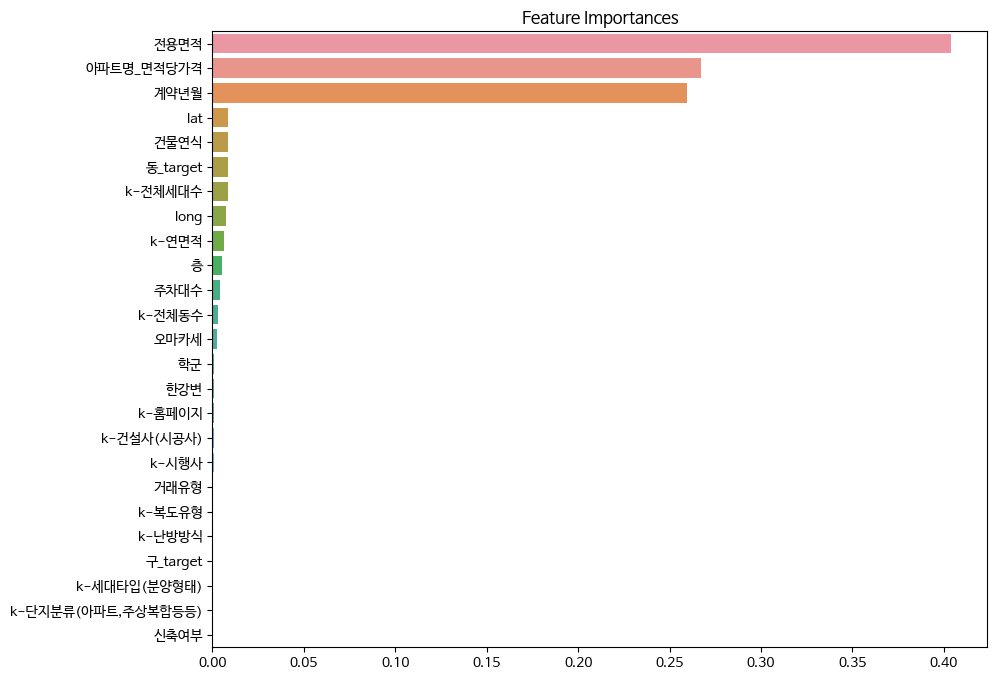

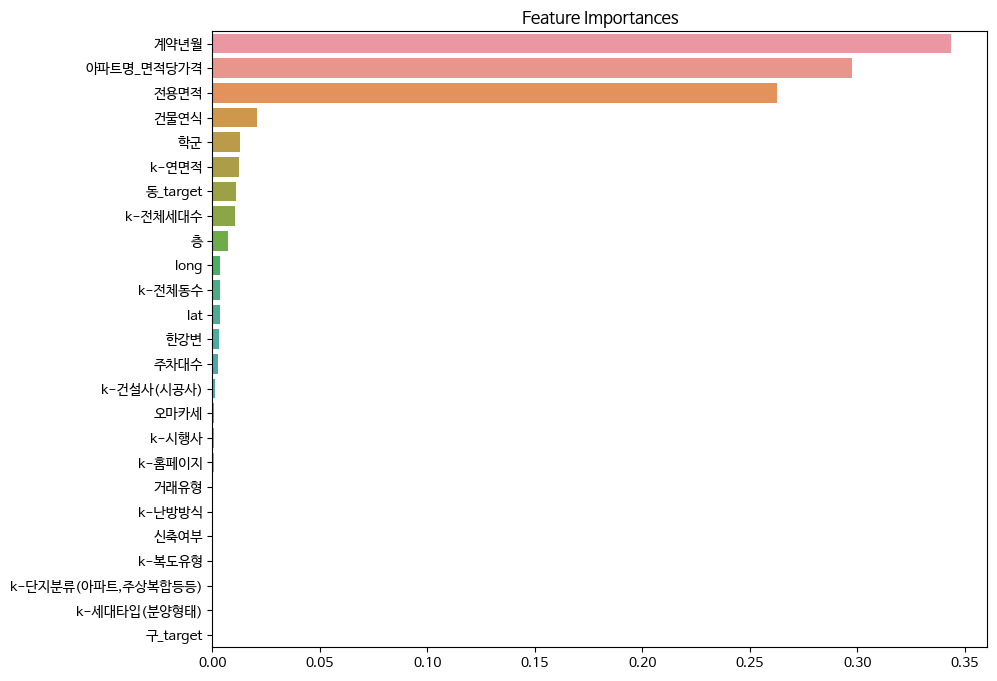

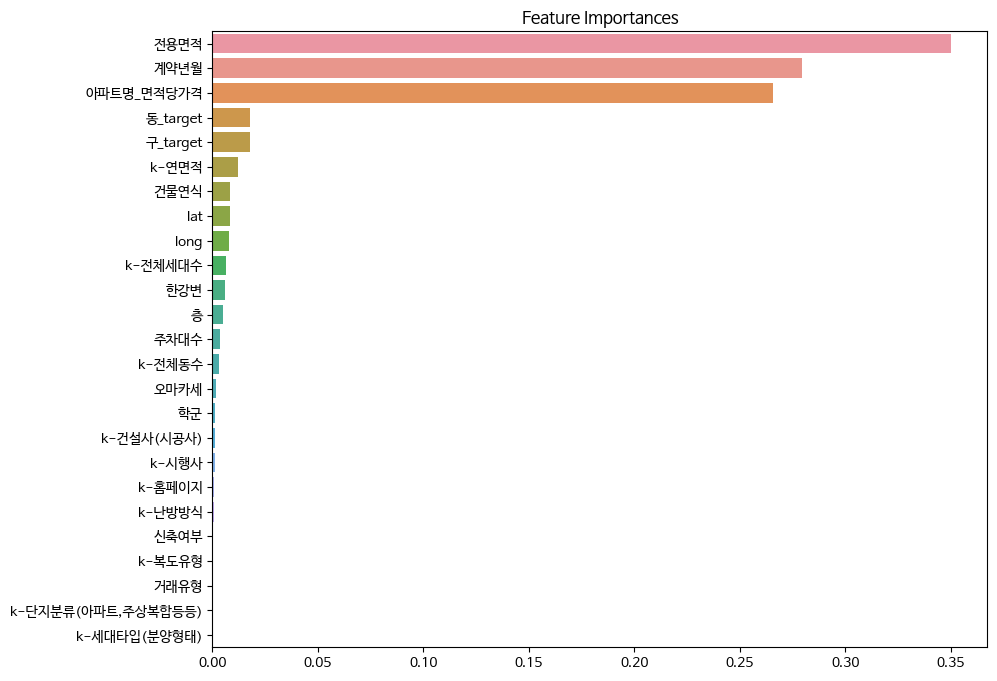

In [194]:
#Í∞Å Î™®Îç∏Ïùò feature_importances plot 
model_high = high_models[0]
model_mid = mid_models[0]
model_low = low_models[0]

importances = pd.Series(model_high.feature_importances_, index=features)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

importances = pd.Series(model_mid.feature_importances_, index=features)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

importances = pd.Series(model_low.feature_importances_, index=features)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [170]:
def inference(models, df_train, df_test, group) -> tuple[np.ndarray, np.ndarray]:
    df_group_train = df_train[df_train['Íµ¨'].isin(group)]
    df_group_test = df_test[df_test['Íµ¨'].isin(group)]
    test_idx = df_group_test.index
    # Íµ¨ target encoding
    train_df, test_df = target_encoding(df_group_train, df_group_test, 'target', 'Íµ¨')
    # Îèô target encoding
    train_df, test_df = dong_target_encoding(train_df, test_df, 'target')

    # ÏïÑÌååÌä∏Î™Ö target encoding
    train_df, test_df = apartment_target_encoding(train_df, test_df, 'target')

    # Í≥ÑÏïΩÎÖÑÏõî target encoding
    train_df, test_df = contract_encoding(train_df, test_df)

    numeric_features = test_df.select_dtypes(include=[np.number]).columns
    #Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨
    test_df[numeric_features] = test_df[numeric_features].interpolate(method='linear', axis=0).fillna(method='bfill').fillna(method='ffill')

    preds = []
    for model in models:
        pred = model.predict(test_df)
        preds.append(pred)
    pred = np.mean(preds, axis=0)

    return pred, test_idx

In [171]:
categorical_features = df_train.select_dtypes(include=[np.object]).columns

df_train[categorical_features] = df_train[categorical_features].fillna('NULL')
df_test[categorical_features] = df_test[categorical_features].fillna('NULL')

#Î†àÏù¥Î∏î Ïù∏ÏΩîÎî©
df_train, df_test, label_encoders = label_encoding(df_train, df_test, excp=['ÏïÑÌååÌä∏Î™Ö', 'Íµ¨', 'Îèô'])

pred_high, high_idx = inference(high_models, df_train, df_test, high_group)
pred_mid, mid_idx = inference(mid_models, df_train, df_test, mid_group)
pred_low, low_idx = inference(low_models, df_train, df_test, low_group)

#ÏòàÏ∏° Í≤∞Í≥º Ìï©ÏπòÍ∏∞
pred_high = pd.Series(pred_high, index=high_idx)
pred_mid = pd.Series(pred_mid, index=mid_idx)
pred_low = pd.Series(pred_low, index=low_idx)

pred = pd.concat([pred_high, pred_mid, pred_low], axis=0).sort_index()

# Í∞í Ï†ïÏàòÌôî, pred Ïª¨ÎüºÎ™Ö Î≥ÄÍ≤Ω
pred = pred.astype(int)
pred = pred.rename('target')
pred.to_csv('./../../Datas/pred_high_mid_low.csv', index=False)




100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 9/9 [00:04<00:00,  1.84it/s]


In [152]:
pred.to_csv('./../../Datas/pred_high_mid_low.csv', index=False)

In [150]:
dd = pd.read_csv('./../../Datas/pred_high_mid_low.csv')
dd.head()

0
0  217004
1  313473
2  330440
3  299274
4  210740